In this example we adress the topic of random wind load. The characteristic of a typical wind storm of 10 minutes duration is normal distributed. Besides the average and the standard deviation, additionally the spectral composition of the fluctuating wind load is important.

Generally, the gust spectrum $S_{uu}(f)$ describes the frequency content of flow energy. Wind has higher energetic content in lower frequent ranges. The integral of $S_{uu}(f)$ equals the variance of the of the wind speed: $\sigma^2=\int_0^\infty S_{uu}(f) df$.

First part: definition of the wind spectrum. Here we use the Kaimal spectrum according to EN 1991-1-4:2010.

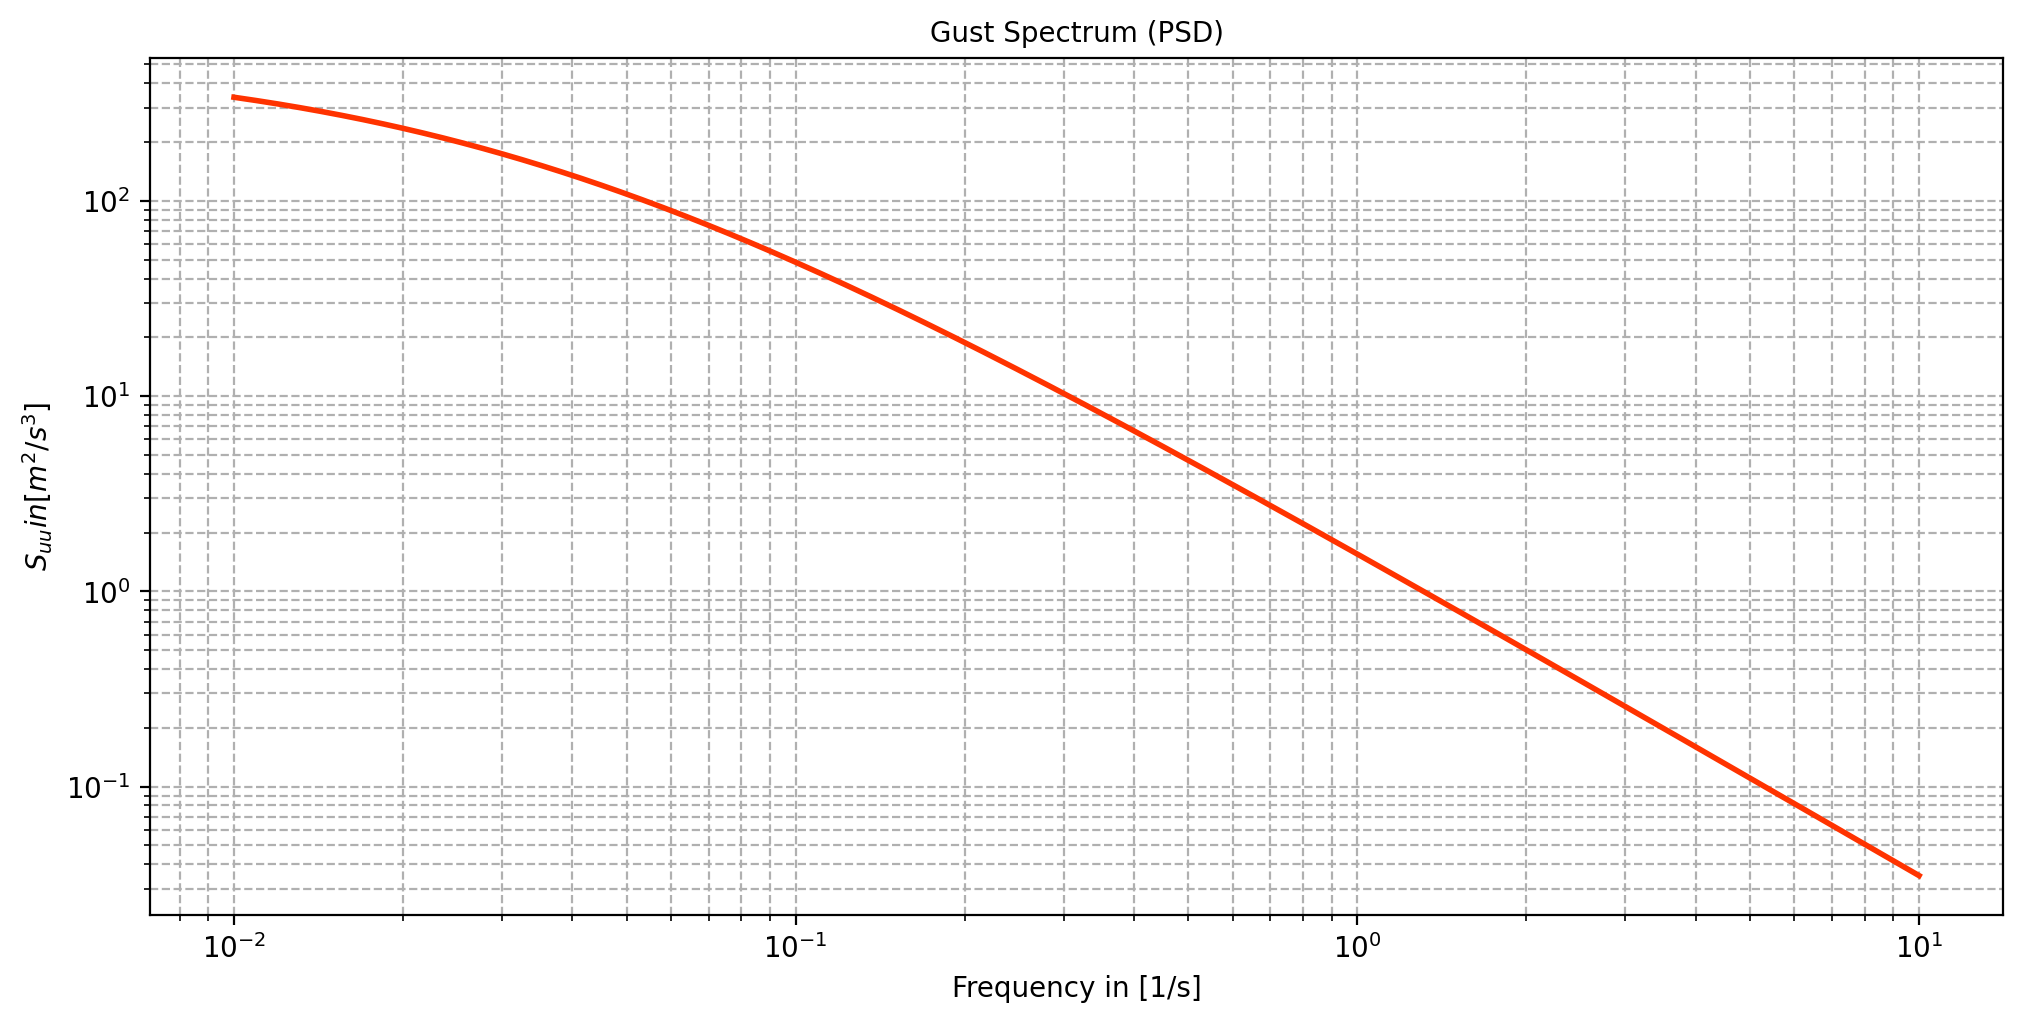

In [2]:
# Import necessary libraries
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import ifft
#from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d

# Setting plot defaults
plt.rcParams.update({
    'font.size': 10,           # Global font size for all text elements
    'axes.titlesize': 10,      # Specific size for subplot titles
    'figure.dpi': 200,         # Set consistent DPI for all figures
})

# Define colors
c1 = [0.2, 0.4, 0.8]
c2 = [1.0, 0.2, 0.0]
c3 = [0.3, 0.8, 0.6]
c4 = [0.8, 0.2, 0.8]

# Wind Climate Variables
vm = 25.0    # Mean velocity in [m/s] @ height z
Iv = 0.2     # Turbulence intensity in [-] @ height z: defined as (standard deviation)/(average velocity)
Lux = 80     # Integral length scale in [m] @ height z

# Frequency range for gust spectrum
f = np.linspace(0.01, 10, int(1E6))
Suu = 6.8 * Iv**2 * vm * Lux / ((1 + 10.2 * f * Lux / vm)**(5/3))

def fTimeSerie(f, y):
    """
    Generate a time series based on a PSD description.
    
    Parameters:
    f : array-like
        Frequency array
    y : array-like
        Power spectral density (PSD) values at each frequency in `f`
    
    Returns:
    t : numpy array
        Time array corresponding to the generated time series
    x : numpy array
        Generated time series based on the input PSD
    """
    N = len(f)               # Number of points in the frequency array
    Fs = f[1] - f[0]         # Frequency step
    Tges = 1 / Fs            # Total time
    Nt = 2 * N + 1           # Number of time steps for the time series
    
    # Step (1): Spectral values from PSD
    SpecSu = y.copy()
    
    # Step (2): Convert from PSD to two-sided Fourier Spectrum
    SpecSu = np.sqrt(f[-1]) * np.sqrt(Nt) * np.sqrt(SpecSu)
    
    # Step (3): Construct the symmetric spectrum for IFFT
    SpecSu_full = np.concatenate(([SpecSu[0]], SpecSu, SpecSu[::-1]))

    # Generate random phase angles between -pi and pi
    thetaSingleSided = np.random.uniform(-np.pi, np.pi, N)
    theta_full = np.concatenate(([thetaSingleSided[0]], thetaSingleSided, thetaSingleSided[::-1]))
    
    # Compute the complex spectrum for IFFT
    R = np.abs(SpecSu_full)
    x_complex = R * np.exp(1j * theta_full)
    
    # Inverse FFT to generate time series
    x = ifft(x_complex, Nt).real
    
    # Define the time array
    Tdelta = Tges / Nt
    t = np.linspace(0, Tdelta * (len(x) - 1), len(x))
    
    return t, x

# Plot gust spectrum
plt.figure(figsize=(10, 5), dpi=200, constrained_layout=True)
plt.loglog(f, Suu, color=c2, linewidth=2)
plt.grid(True, which="both", ls="--")
plt.xlabel('Frequency in [1/s]')
plt.ylabel('$S_{uu} in [m^2/s^3]$')
plt.title('Gust Spectrum (PSD)', fontsize=10)
plt.savefig('01-Spectrum.pdf', format='pdf', dpi=200)
plt.savefig('02-Spectrum.png', format='png', dpi=200)

plt.show()




Based on the gust spectrum, a time-series is generated. It is valid for a single point, considering three input parameters: average wind speed $u_m$, turbulence intensity $I_u$ and integral legth scale of turbulence $L_{ux}$. The time signal is generated via inverse fourier transformation considerung random phase angles (uniforomly distributed).

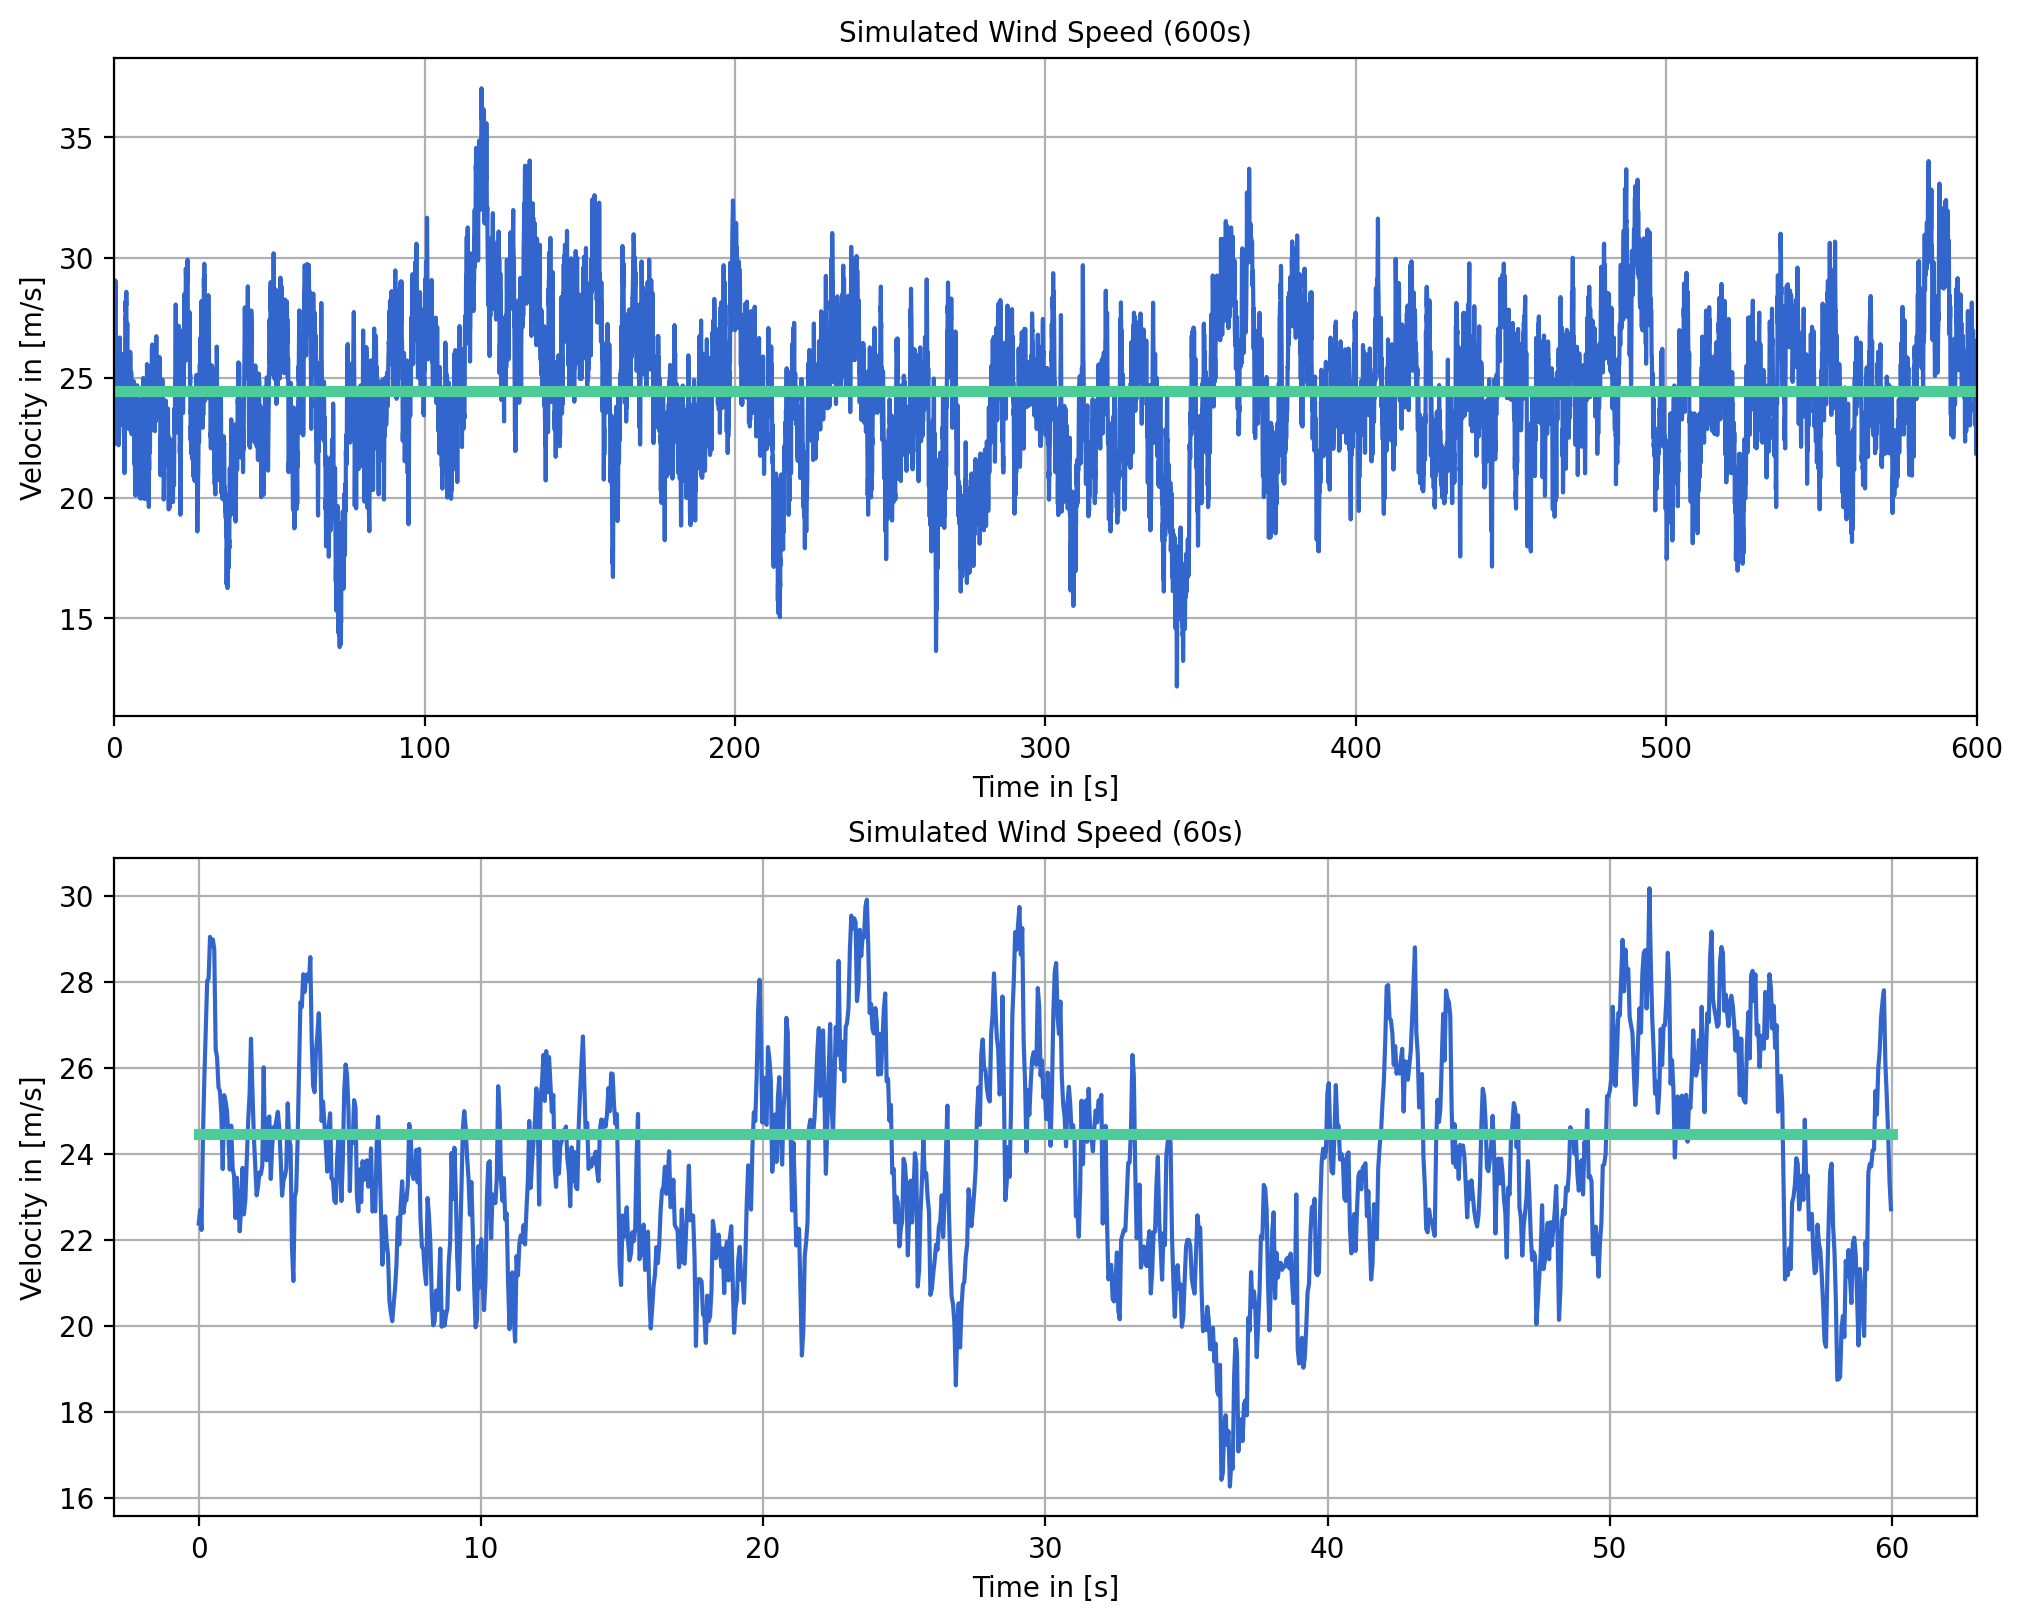

In [3]:
# Inverse FFT for time series simulation (example with random values)
t, u = fTimeSerie(f, Suu)

# Plotting the time series (10 min and zoomed to 60s)
plt.figure(figsize=(10, 8), constrained_layout=True)
plt.subplot(2, 1, 1)
plt.plot(t[t <= 600], vm + u[t <= 600], color=c1)
plt.xlim([0, 600])
vmean = np.mean(vm + u[t <= 600])
plt.plot([0, 600], [vmean, vmean], color=c3, linewidth=4)
plt.grid()
plt.xlabel('Time in [s]')
plt.ylabel('Velocity in [m/s]')
plt.title('Simulated Wind Speed (600s)')

plt.subplot(2, 1, 2)
plt.plot(t[t <= 60], vm + u[t <= 60], color=c1)
plt.plot([0, 60], [vmean, vmean], color=c3, linewidth=4)
plt.grid()
plt.xlabel('Time in [s]')
plt.ylabel('Velocity in [m/s]')
plt.title('Simulated Wind Speed (60s)')
plt.savefig('02-TimeSeries10min.pdf', format='pdf', dpi=200)
plt.savefig('02-TimeSeries10min.png', format='png', dpi=200)
plt.show()


The time resolution of the generated time series is $dt$. The smaller $dt$, the higher the relevant peaks. Howeverm with repsect to wind loading, it does not make sense to consider extremely small time steps. Typically a moving average of 3s is therefore used, which is refered to as gust duration.

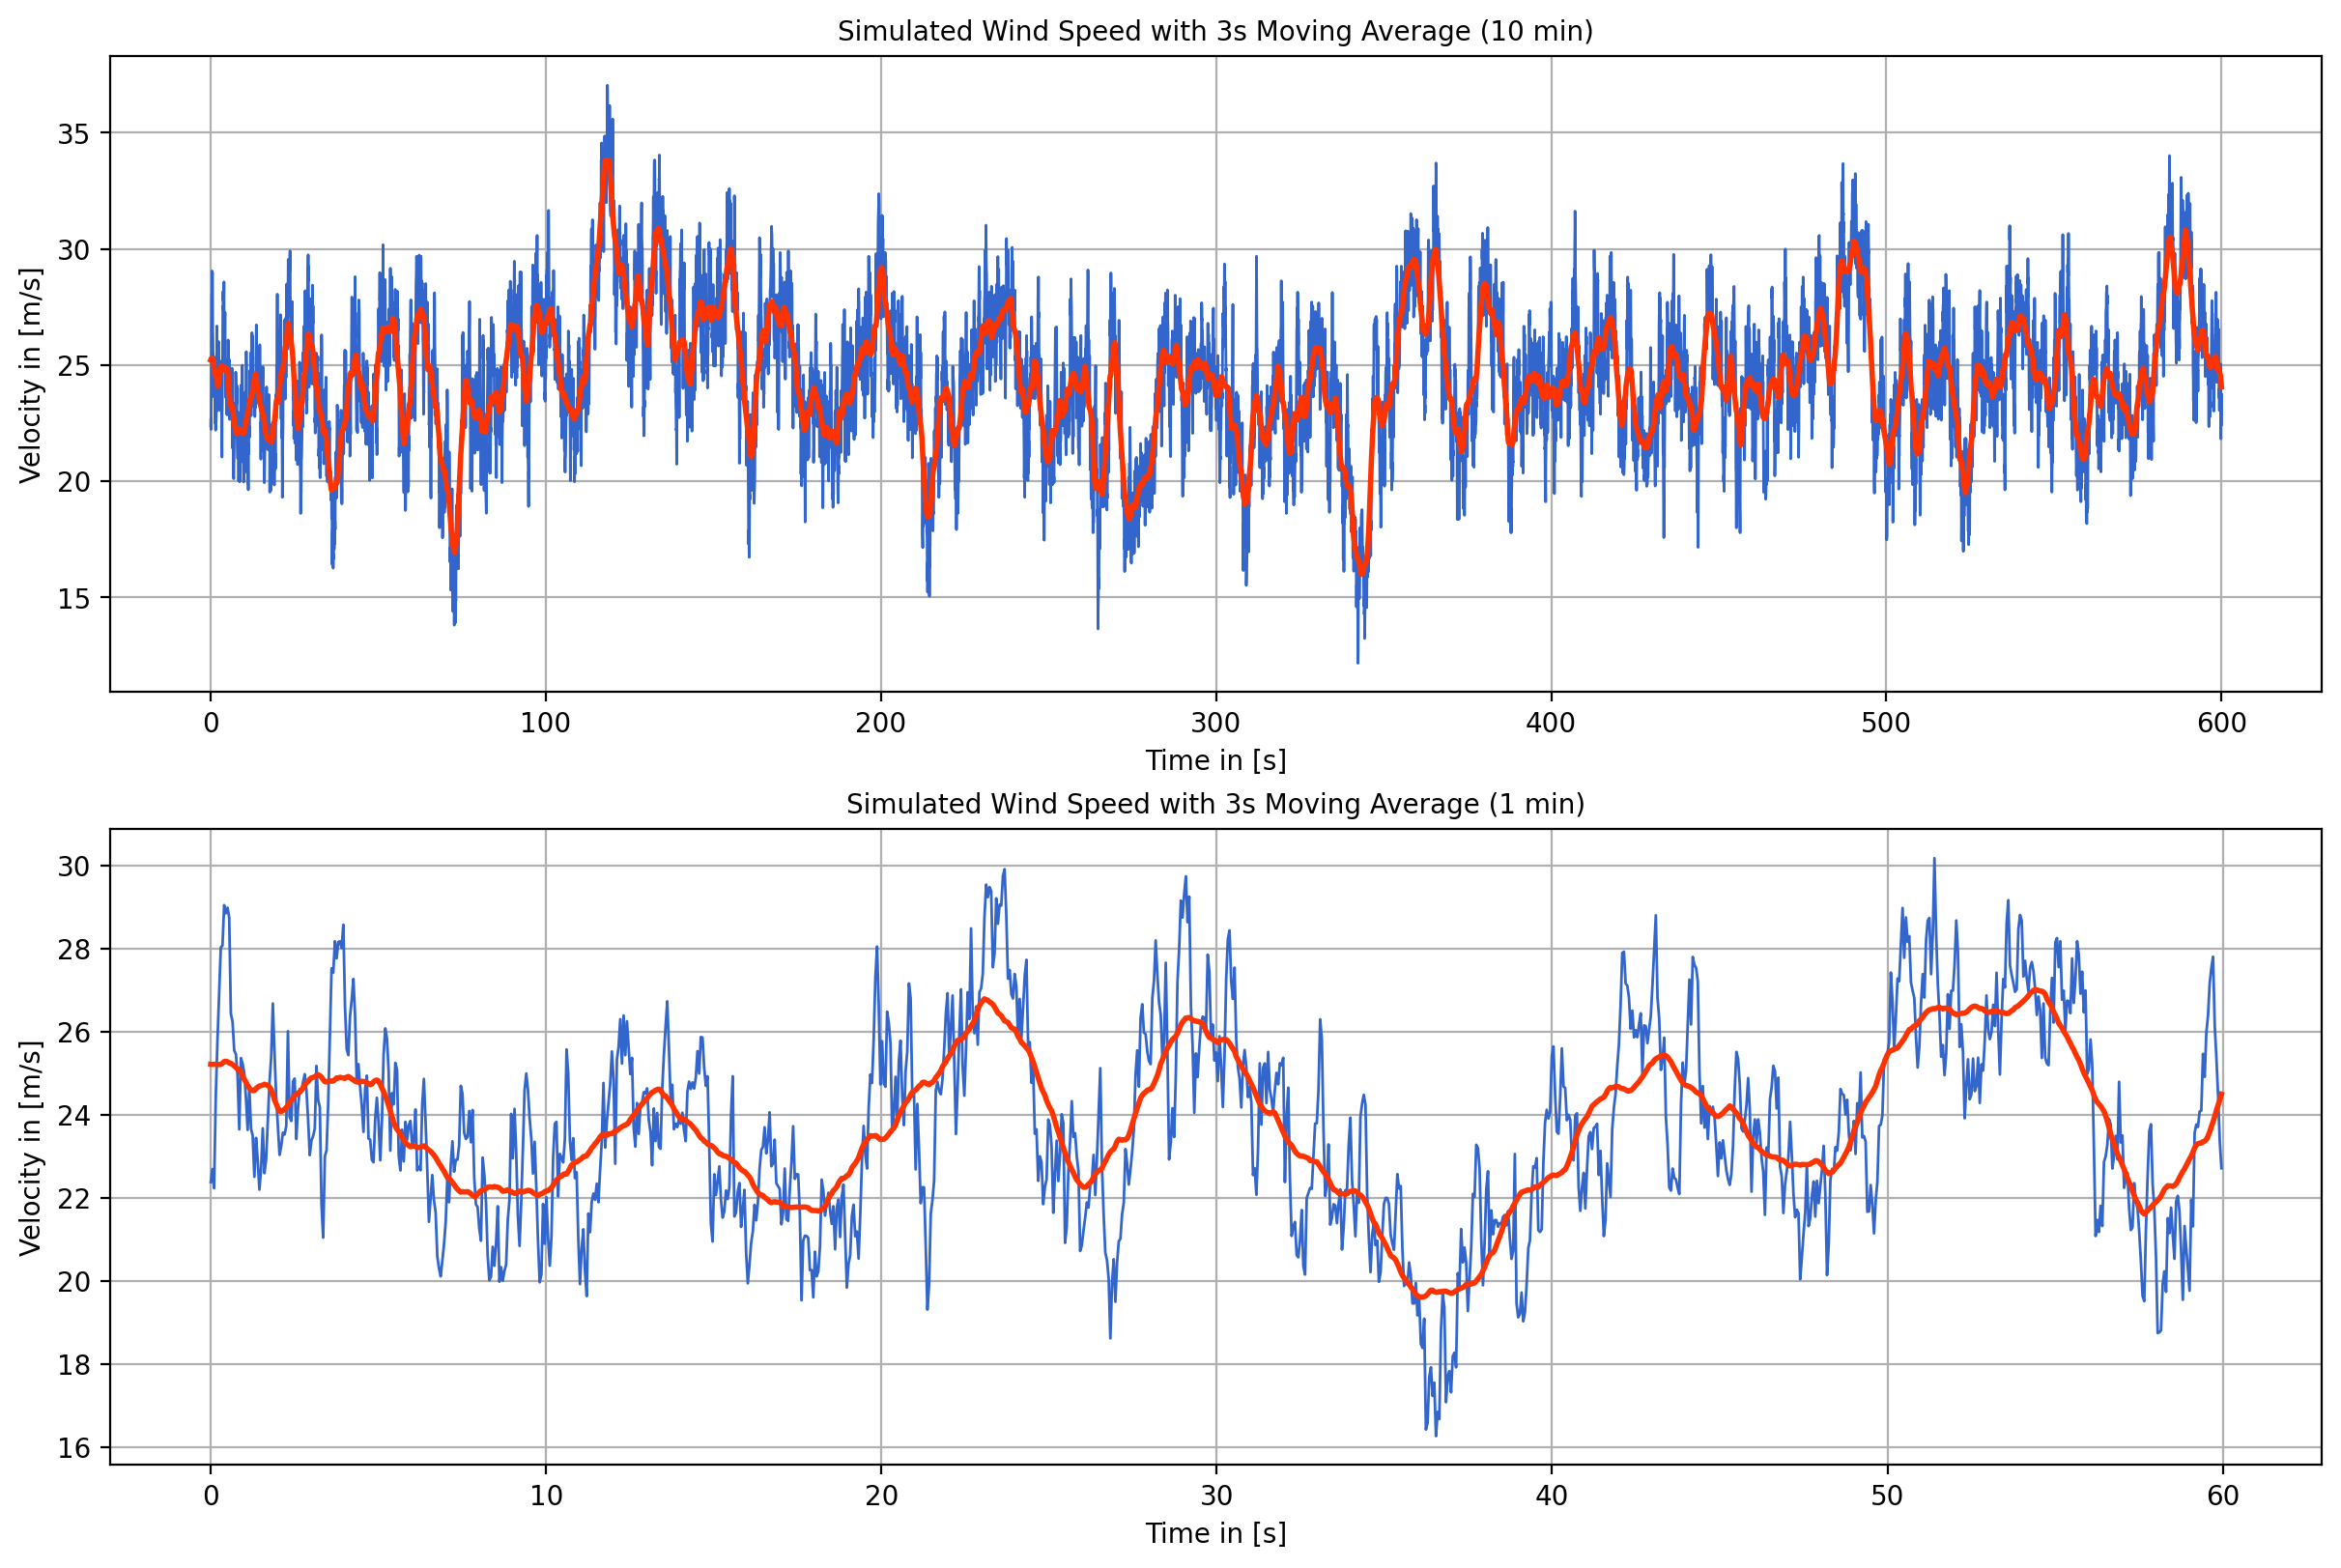

Gust factor: 1.44 - red curve max divided by green line


In [4]:

dt = t[1] - t[0]  # Time step
u3 = uniform_filter1d(u, size=int(3 / dt))  # 3-second moving average

# Reduce to a 10-minute time series (600 seconds)
t10 = t[t <= 600]
u10 = u3[t <= 600] + vm  # Add mean velocity to the 3-second averaged series
u3max = np.max(u10)
iu3max = np.argmax(u10)

# Plot 10-minute and 1-minute segments
plt.figure(figsize=(12, 8), constrained_layout=True)

# 10-minute segment with moving average
plt.subplot(2, 1, 1)
plt.plot(t10, vm + u[t <= 600], color=c1, linewidth=1)
plt.plot(t10, vm + u3[t <= 600], color=c2, linewidth=2)
plt.axhline(y=u3max, color=c4, linewidth=4, xmin=(t[0] if iu3max - 200 < 0 else t[iu3max - 200]),
            xmax=t[min(iu3max + 200, len(t) - 1)])  # Highlighting max segment
plt.grid()
plt.xlabel('Time in [s]')
plt.ylabel('Velocity in [m/s]')
plt.title('Simulated Wind Speed with 3s Moving Average (10 min)')

# 1-minute (60s) segment with moving average
plt.subplot(2, 1, 2)
plt.plot(t[t <= 60], vm + u[t <= 60], color=c1, linewidth=1)
plt.plot(t[t <= 60], vm + u3[t <= 60], color=c2, linewidth=2)
plt.grid()
plt.xlabel('Time in [s]')
plt.ylabel('Velocity in [m/s]')
plt.title('Simulated Wind Speed with 3s Moving Average (1 min)')
plt.savefig('02-TimeSeries10min3sFilter.pdf', format='pdf', dpi=200)
plt.savefig('02-TimeSeries10min3sFilter.png', format='png', dpi=200)
plt.show()

# Calculate gust factor
up=np.max(u3 + vm) #gust velocity or peak velocity
gf = np.max(u3 + vm) / np.mean(u3 + vm) 
print(f"Gust factor: {gf:.2f} - red curve max divided by green line")



Now we calculate structural loading in the time domain for the time series:

$F=A\cdot c_f \cdot \rho/2 \cdot u_p^2(t)$

where:
$A$: is the wind loaded area, e.g. A=10m^2
$c_f$: Aerodynamic coefficient, e.g. 2.0 for a rectangular, 1.2 for a circle
$\rho$: density air 1.25kg/m^3




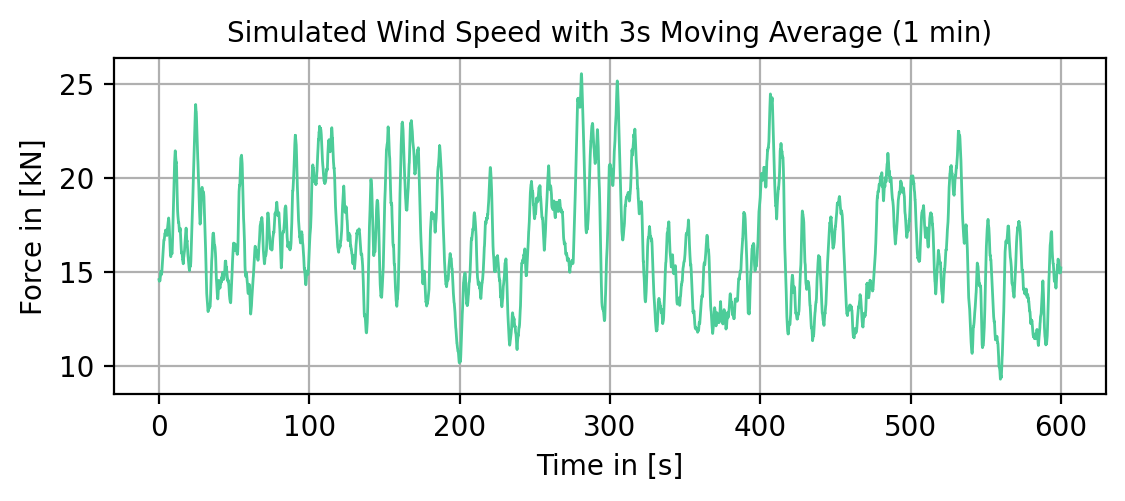

In [13]:
A=10    #assumed wind loaded area
c_f=2   #aerodynamic coefficient
rho=1.25#density of air
 
F=A*c_f*rho*(u3+vm)**2/1000 # in kN

# 1-minute (60s) segment with moving average
plt.subplot(2, 1, 2)
plt.plot(t[t <= 600], F[t <= 600], color=c3, linewidth=1)
plt.grid()
plt.xlabel('Time in [s]')
plt.ylabel('Force in [kN]')
plt.title('Simulated Wind Speed with 3s Moving Average (1 min)')
#plt.savefig('02-TimeSeries10min3sFilter.pdf', format='pdf', dpi=200)
#plt.savefig('02-TimeSeries10min3sFilter.png', format='png', dpi=200)
plt.show()


Now we have a look at the distributrions. First, the distribution of the wind velocity.

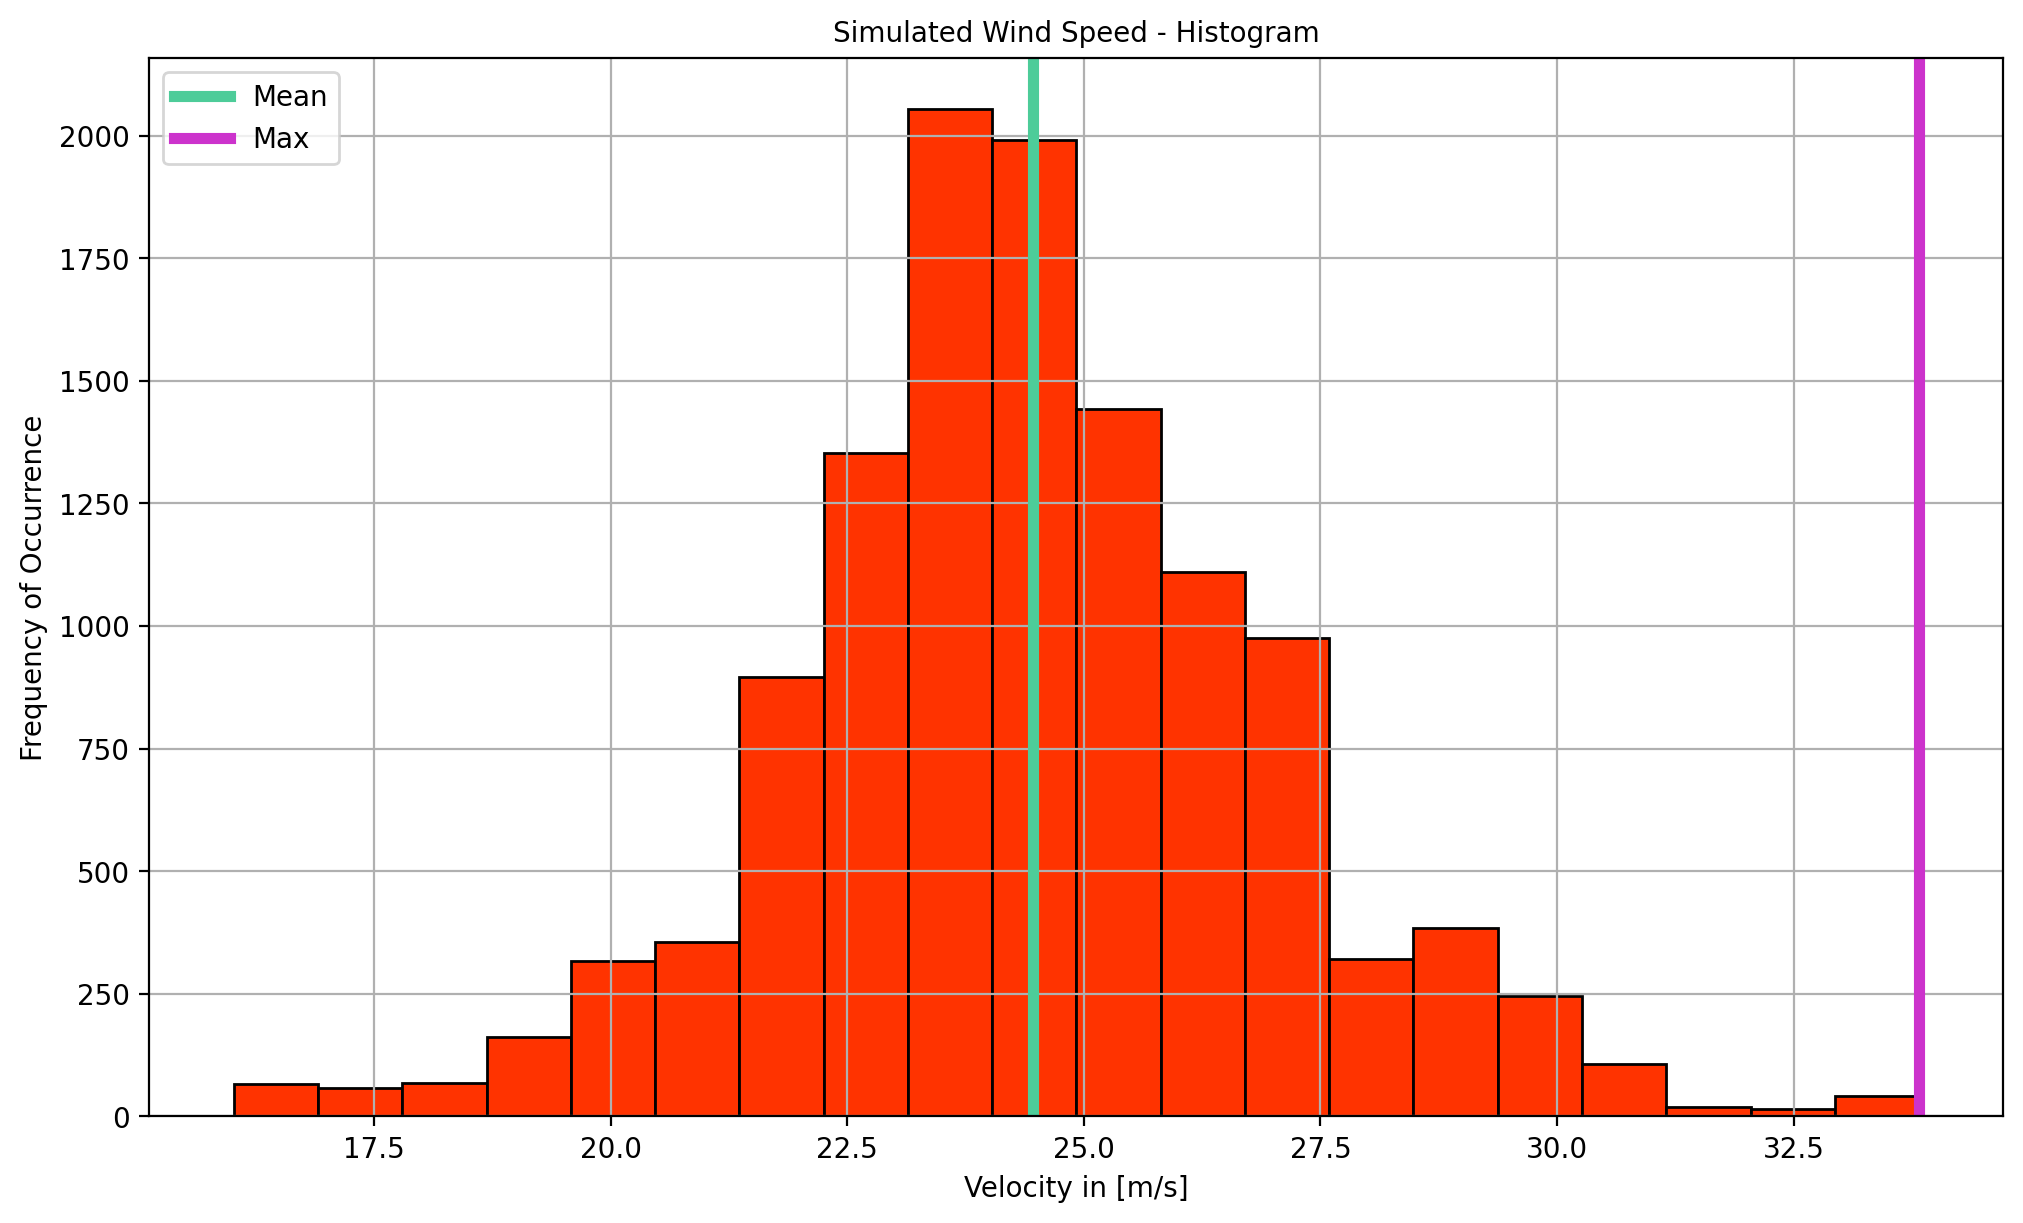

In [ ]:
# Histogram of the 10-minute time series
plt.figure(figsize=(10, 6), constrained_layout=True)
plt.hist(u10, bins=20, color=c2, alpha=1, edgecolor='black')
plt.axvline(np.mean(u10), color=c3, linewidth=4, label='Mean')
plt.axvline(u3max, color=c4, linewidth=4, label='Max')
plt.grid()
plt.xlabel('Velocity in [m/s]')
plt.ylabel('Frequency of Occurrence')
plt.title('Simulated Wind Speed - Histogram')
plt.legend()
plt.savefig('02-TimeSeriesHistogram.pdf', format='pdf', dpi=200)
plt.show()

#Tasks: 
#Repeat the generation several times - which values are changing?
#Modify the input parameters and check the influence on the resulting charts
#Insert a loop for the generation of wind speed and store the data [up, gf] (n=30 runs).
#Perform an analysis of the distribution of the average and maximum values of n data fields.

AttributeError: Rectangle.set() got an unexpected keyword argument 'display_pdf'

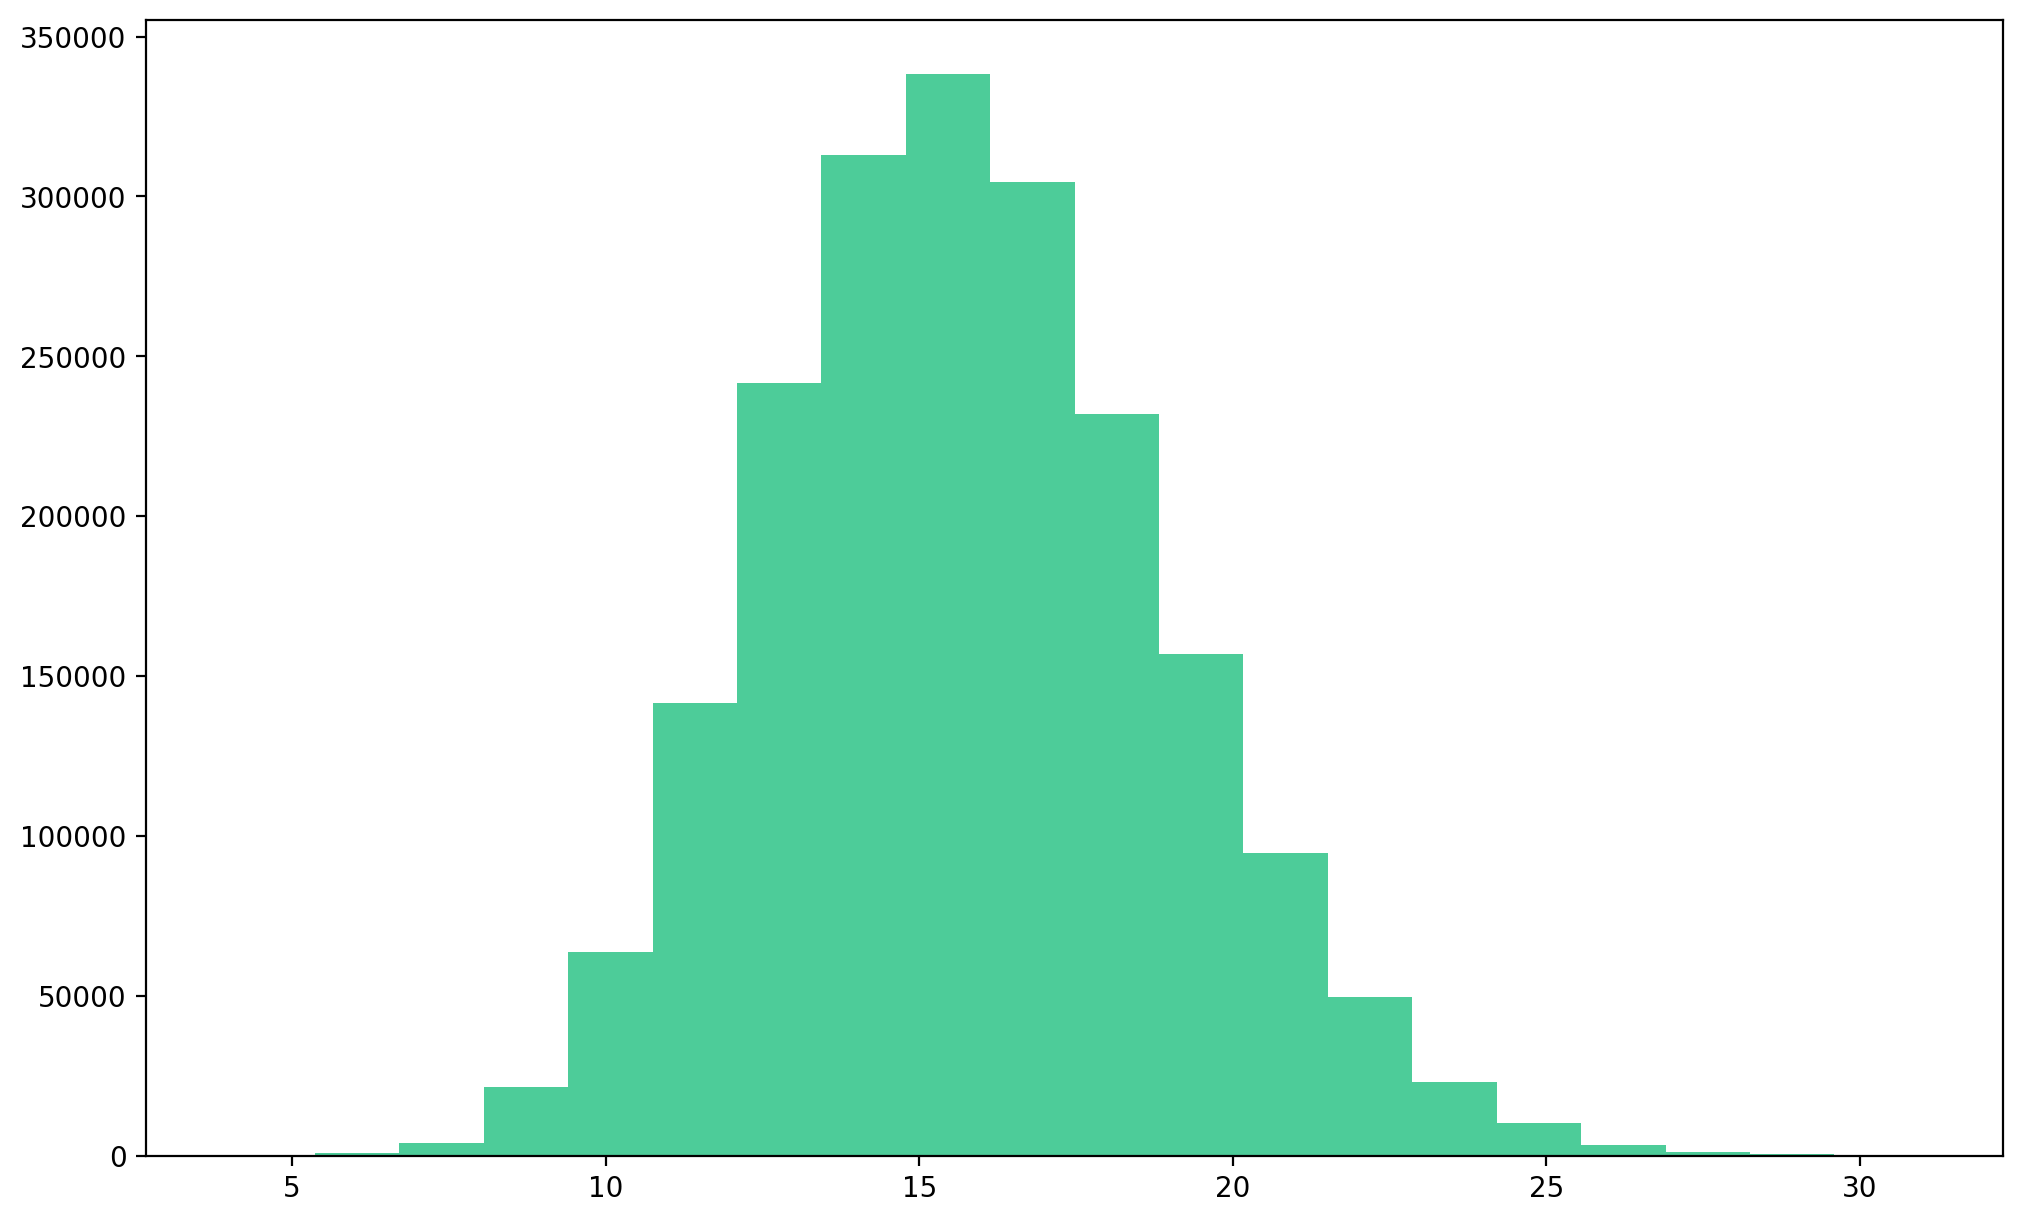

In [ ]:
# Histogram of the 10-minute time series
plt.figure(figsize=(10, 6), constrained_layout=True)
plt.hist(F, bins=20, color=c3, ddensity=True , alpha=1, edgecolor='black')
plt.grid()
plt.xlabel('Force in [kN]')
plt.ylabel('Frequency of Occurrence')
plt.title('Structural Force (example) - Histogram')
#plt.legend()
plt.savefig('04-TimeSeriesForce.png', format='png', dpi=200)
plt.show()

In  this section we want to run the time series generation $n$ times and anlysis the statistical results.

/tmp/ipykernel_2109/321720894.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


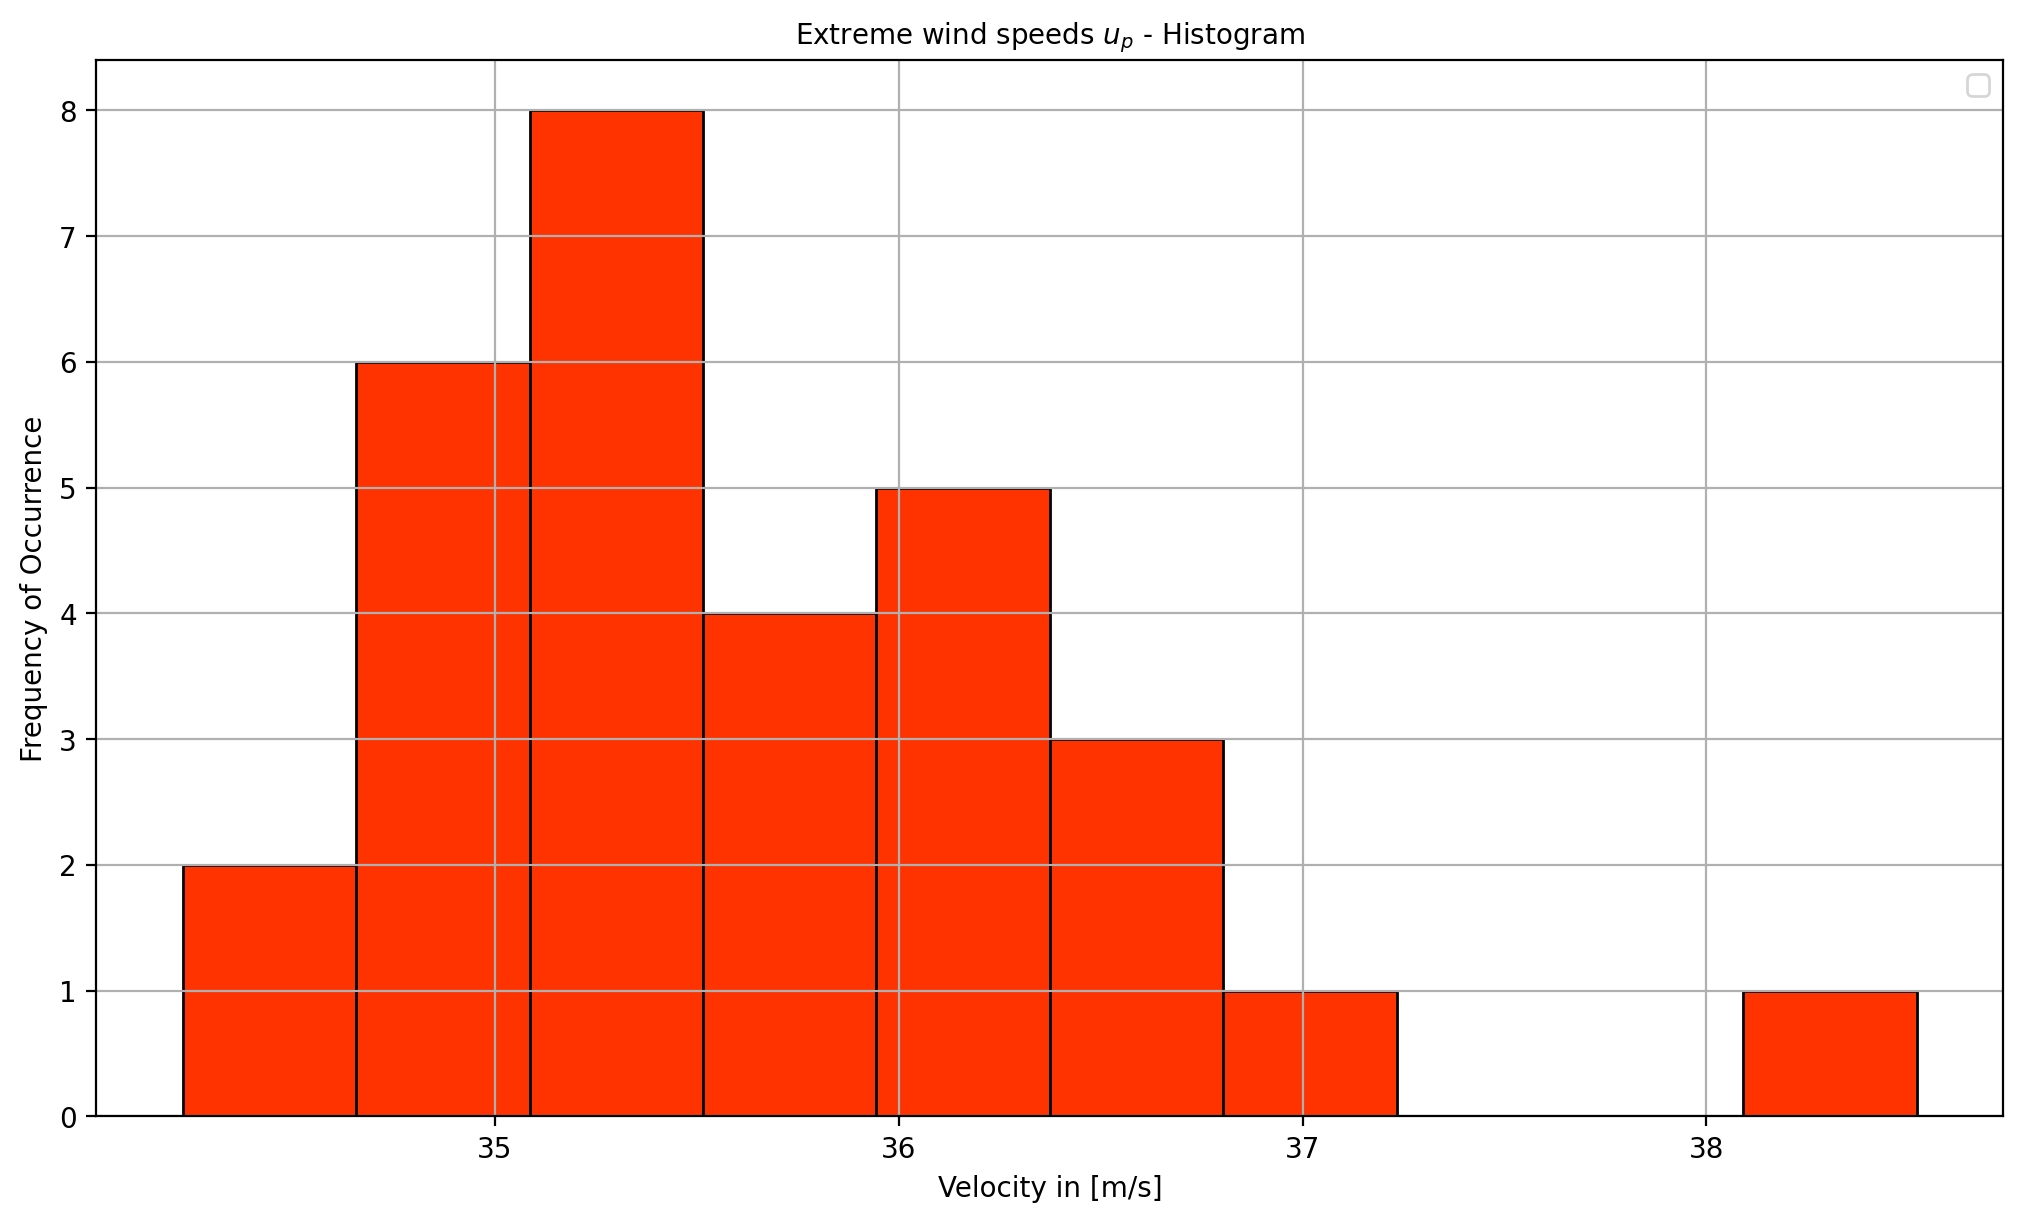

/tmp/ipykernel_2109/321720894.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


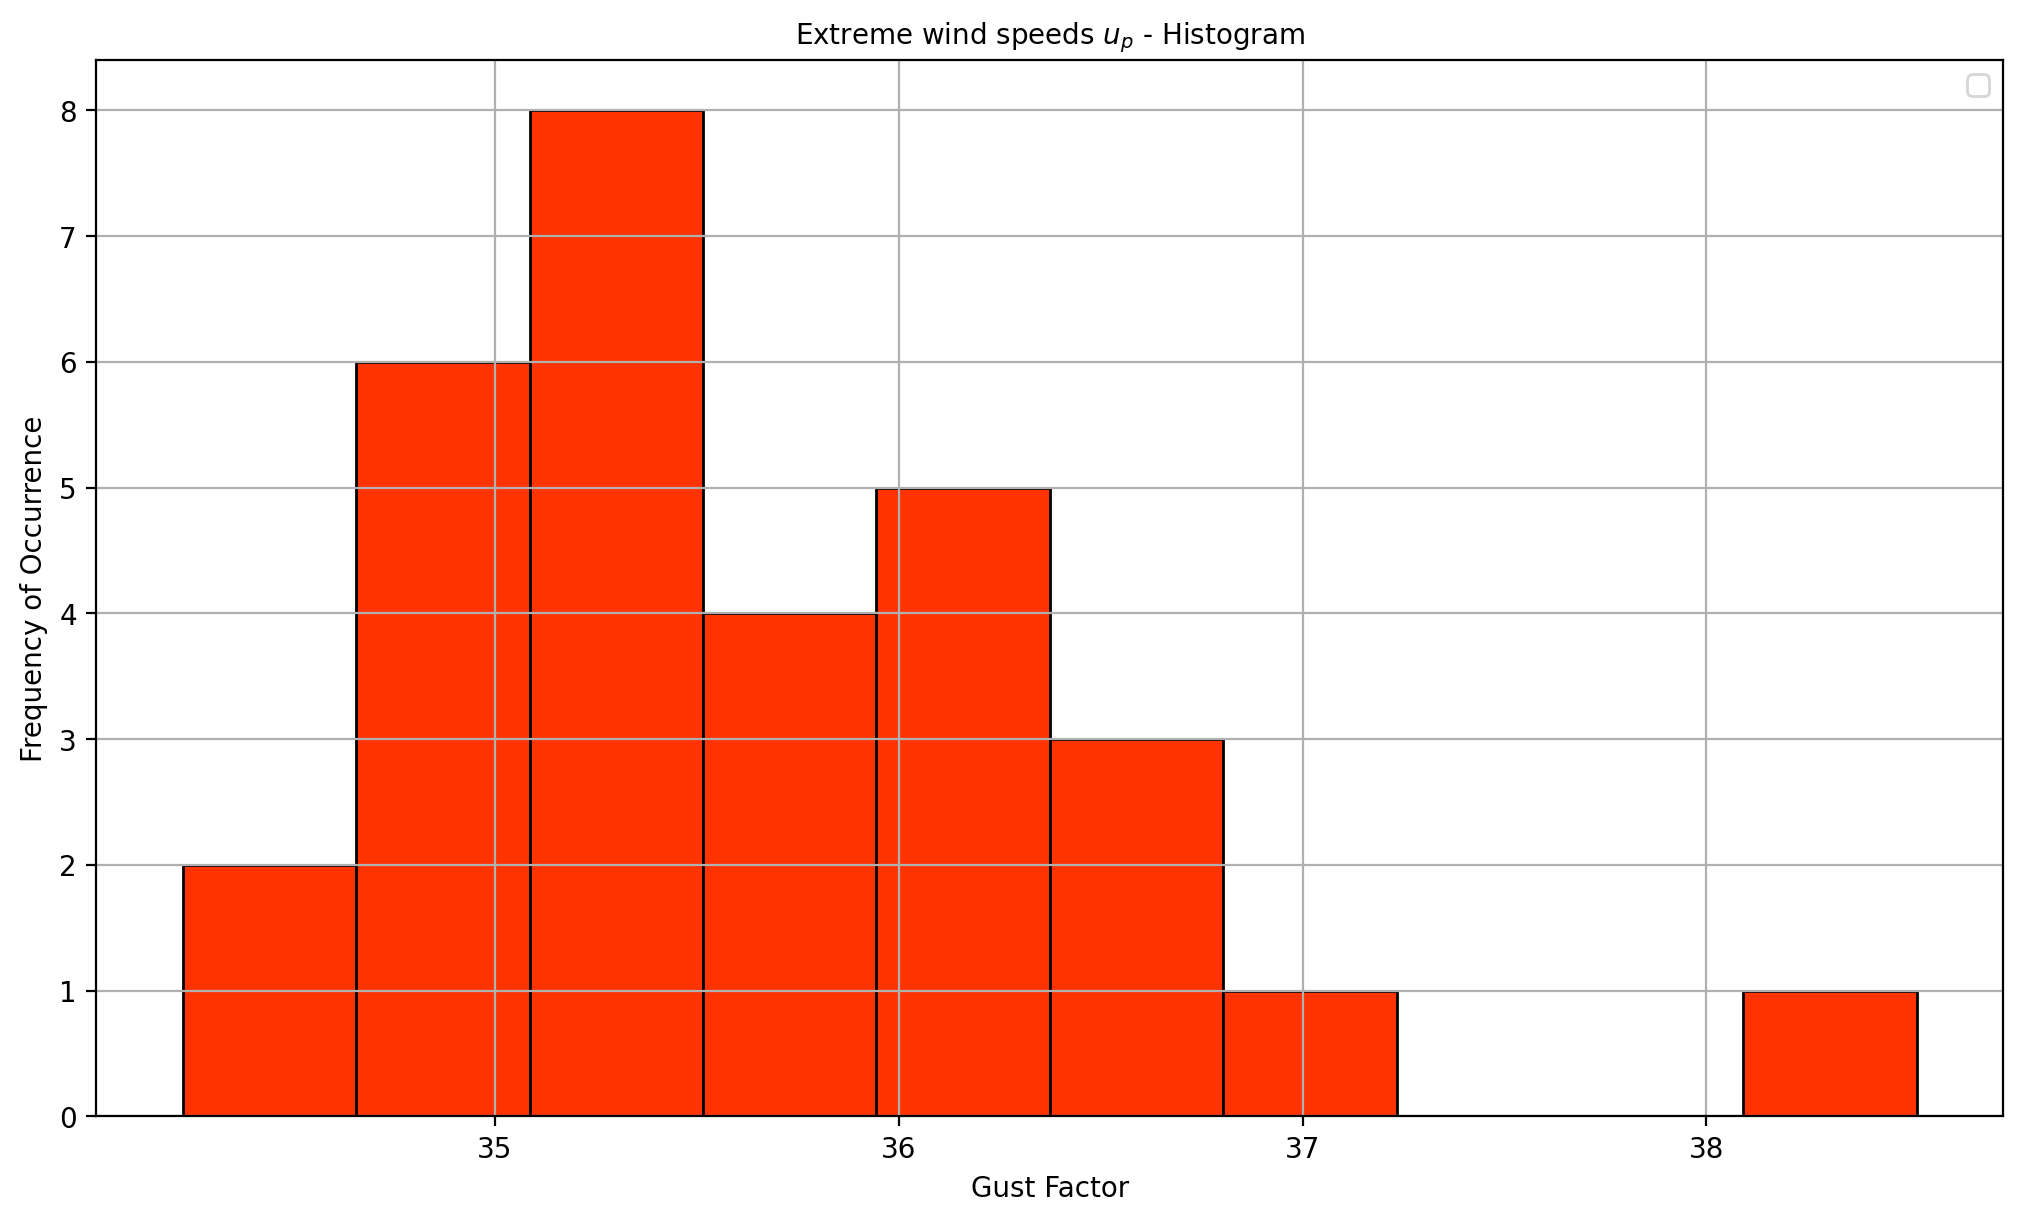

In [7]:


# Inverse FFT for time series simulation (example with random values)

n=30 #Number of loops
gf_arr=np.zeros((n,1)) #arrange the data array
up_arr=np.zeros((n,1)) #arrange the data array

for i in range(0,n):
    t, u = fTimeSerie(f, Suu)
    dt = t[1] - t[0]  # Time step
    u3 = uniform_filter1d(u, size=int(3 / dt))  # 3-second moving average
    up=np.max(u3 + vm) #gust velocity or peak velocity
    gf = np.max(u3 + vm) / np.mean(u3 + vm) 
    #print(f"Gust factor: {gf:.2f}, Peak velocity: {up:.2f} m/s")
    #Store the data
    up_arr[i]=up;gf_arr[i]=gf

#print(up_arr)

plt.figure(figsize=(10, 6), constrained_layout=True)
plt.hist(up_arr, color=c2, alpha=1, edgecolor='black')
plt.grid()
plt.xlabel('Velocity in [m/s]')
plt.ylabel('Frequency of Occurrence')
plt.title('Extreme wind speeds $u_p$ - Histogram')
plt.legend()
plt.savefig('10-Extremes.pdf', format='pdf', dpi=200)
plt.show()

plt.figure(figsize=(10, 6), constrained_layout=True)
plt.hist(up_arr, color=c2, alpha=1, edgecolor='black')
plt.grid()
plt.xlabel('Gust Factor')
plt.ylabel('Frequency of Occurrence')
plt.title('Extreme wind speeds $u_p$ - Histogram')
plt.legend()
plt.savefig('10-Extremes.pdf', format='pdf', dpi=200)
plt.show()

